In [1]:
import numpy as np
import gym_maze.envs.maze_env as maze

pygame 2.2.0 (SDL 2.0.22, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib.pyplot as plt


In [3]:
import gym
import cv2
# gray scaled observation
class MyEnv(maze.MazeEnv):
    def __init__(self,obs_shape=(250,250),**kwargs):
        self.obs_shape = obs_shape
        super().__init__(**kwargs)
        rescue_item_locs = self.maze_view.rescue_item_locations
        maze_size = self.maze_view.maze_size
        self.final_pos = (maze_size[0]-1,maze_size[1]-1)
        shape=  obs_shape+(1,)
        self.observation_space = gym.spaces.Box(low=0,high=255,shape=shape,dtype=np.uint8)
        self.obs_shape = obs_shape
        self.MIN_REWARD = -1
        self.MAX_REWARD = 1
        self.target_locs = rescue_item_locs+[self.final_pos]
        self.prev_pos = (0,0)
        self.total_reward = 0
        self.MIN_REWARD_TH = -100  
        self.MAXIMUM_CRASHES = 50 
        self.keys = ['N', 'E', 'S', 'W']
        
    def _get_reward(self,cur_pos):
        terminated = False
        if cur_pos==self.prev_pos:
            self.count_crash+=1
            reward = self.MIN_REWARD
            if self.count_crash> self.MAXIMUM_CRASHES:
                terminated = True
            
            
        elif cur_pos in self.target_locs:
            if cur_pos == self.final_pos and len(self.target_locs)!=1:
                reward = self.MIN_REWARD+0.5
                terminated = True         
            else:
                idx = self.target_locs.index(cur_pos)
                reward = self.MAX_REWARD/len(self.target_locs)
                del self.target_locs[idx]         
        else:
            reward = -0.05
   
        self.prev_pos = cur_pos
        return reward,terminated
    def step(self,action):
        action = int(action)
        action = self.keys[action]
        logs,_,_,_,info = super().step(action)
        
        reward,terminated = self._get_reward(tuple(logs[0]))
        self.total_reward+=reward
        if self.total_reward<self.MIN_REWARD_TH or len(self.target_locs)==0:
            terminated = True
        state = self.observation()
        return state,reward,terminated,info
    
    def observation(self):
        state = self.maze_view.update('rgb_array')
        state = cv2.cvtColor(state,cv2.COLOR_RGB2GRAY)
        state = cv2.resize(state,self.obs_shape)
        return state.reshape(state.shape+(1,))
    
    def reset(self):
        super().reset()
        self.count_crash = 0
        self.total_reward = 0
        self.prev_pos = (0,0)
        state = self.observation()
        return state

In [4]:
env = MyEnv(maze_file='hackathon_sample.npy',rescue_item_locations=[(5,4),(2,3),(4,5),(2,1)])

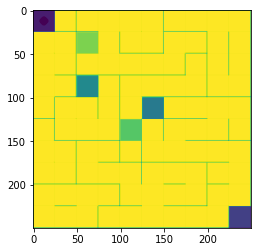

In [5]:
s= env.reset()
plt.imshow(s)

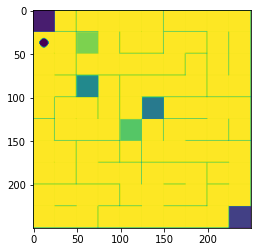

In [6]:
plt.imshow(env.step(2)[0])

In [7]:
from stable_baselines3 import DQN
model = DQN("CnnPolicy",env,buffer_size=10000,tensorboard_log='./logs/')

C:\Users\HP\anaconda3\envs\vip\lib\site-packages\torch\cuda\__init__.py:82: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
model.learn(5000)

In [9]:
!tensorboard --logdir ./logs/

^C


In [10]:
done = False
state = env.reset()
states=[state]
acts = []
rewards =[]
while not done:
    action,_ = model.predict(state)
    next_state,reward,done,info = env.step(action)
    rewards.append(reward)
    states.append(next_state)
    acts.append(action)
    
    
    

In [17]:
env.reset()
env.total_reward

0

In [12]:
import os
import imageio
import shutil
def make_gif(imgs,name='movie'):
    path = 'imgs'
    if os.path.exists(path):
        shutil.rmtree(path) 
    os.makedirs(path)
    ps = []
    for i, img in enumerate(imgs):
        p = os.path.join(path,f'img_{i+1}.jpg')
        cv2.imwrite(p,img)
        ps.append(p)
        
    with imageio.get_writer(f'{name}.gif', mode='I') as writer:
        for p in ps:
            image = imageio.imread(p)
            writer.append_data(image)
           
        
        
make_gif(states)   

C:\Users\HP\anaconda3\envs\vip\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


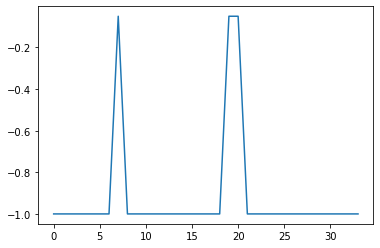

In [11]:
plt.plot(rewards)

[(5, 4), (2, 3), (9, 9)]